In [ ]:
#default_exp model.train

In [ ]:
!nbdev_build_lib

Converted 00_jobs.ipynb.
Converted 01-create-sample-data.ipynb.
Converted 02-preprocess.ipynb.
Converted 03-feature-calc.ipynb.
Converted 04-training-data.ipynb.
Converted 05-train-model.ipynb.
Converted 06-submit-training-pipeline.ipynb.
Converted 99-tools.ipynb.
Converted index.ipynb.


In [ ]:
#export
from typing import Dict, Optional
from datetime import datetime, timezone, timedelta
import os
import random
import uuid
import json
import math
import pickle
import dask.dataframe as dd
import numpy as np

import dask
import dask_xgboost
from dask_ml.model_selection import train_test_split

from hopeit.app.context import EventContext
from hopeit.app.events import Spawn, SHUFFLE
from hopeit.app.api import event_api
from hopeit.app.logger import app_logger

from fraud_poc.jobs import get_client, TrainModelJob, TrainingDataJob

In [ ]:
#export
__steps__ = ['setup', 'train_model', 'validate_model']

logger = app_logger()

In [ ]:
#export
def setup(job: TrainingDataJob, context: EventContext) -> TrainModelJob:
    train_job = TrainModelJob(
        train_data=job.sampled,
        validation_data=job.validation,
        model_path=context.env['model']['path']
    )
    logger.info(context, "Setup {train_job}...")
    return train_job

In [ ]:
#export
def _features_and_labels(df):
    X = df[['order_amount', 
            'num_email_by_customer_id', 'same_email_by_customer_id', 'known_email_by_customer_id', 
            'num_ip_addr_by_customer_id', 'same_ip_addr_by_customer_id', 'known_ip_addr_by_customer_id',
            'num_customer_id_by_email', 'same_customer_id_by_email', 'known_customer_id_by_email',
            'order_amount_mean_by_customer_id',
            'order_amount_std_by_customer_id', 'order_amount_min_by_customer_id', 'order_amount_max_by_customer_id',
            'order_amount_sum_by_customer_id', 
            'order_amount_mean_by_email',
            'order_amount_std_by_email', 'order_amount_min_by_email', 'order_amount_max_by_email',
            'order_amount_sum_by_email']]
    y = df[['is_fraud']]
    return X, y

def _save_model(model, stats, path, version):
    os.makedirs(path, exist_ok=True)
    file_name = f'{path}/{version}.pkl'
    with open(file_name, 'wb') as fb:
        pickle.dump(model, fb)
    with open(f'{path}/{version}-stats.json', 'w') as fb:
        json.dump(stats, fb)
    return file_name

def _load_model(file_name):
    with open(file_name, 'rb') as fb:
        return pickle.load(fb)

def _score(y, y_pred):
    treshold = 0.5
    tp, tn, fp, fn = 0, 0, 0, 0
    for v, p  in zip(y.to_numpy() > treshold, y_pred > treshold):
        if v and p: tp += 1
        elif v and not p: fn += 1
        elif not v and not p: tn += 1
        elif not v and p: fp += 1


    tpr = tp/(tp+fp)
    rec = tp/(tp+fn)
    tnr = tn/(tn+fp)
    acc = (tpr + tnr) / 2
    f1 = 2*(tpr*rec)/(tpr+rec)

    return {
        'tp': tp, 'tn': tn, 'fp': fp, 'fn': fn, 'prec': tpr, 'rec': rec, 'tpr': tpr, 'tnr': tnr, 'acc': acc, 'f1': f1
    }

In [ ]:
#export
def train_model(job: TrainModelJob, context: EventContext) -> Optional[TrainModelJob]:
    client = get_client()
    try:
        logger.info(context, f"Loading training data {job.train_data}...")
        df = dd.read_parquet(job.train_data, engine='fastparquet')
        #df_validation = dd.read_parquet(f'./data/training/validation/', engine='fastparquet')
        X, y = _features_and_labels(df)
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.15)
        #XGBoost
        logger.info(context, f"Training XGBoost model...")
        params = {'objective': 'binary:logistic',
                  'max_depth': 6, 'eta': 0.01,
                  'min_child_weight': 0.5, 'verbosity': 1, 'tree_method': 'hist'}
        evals = {}
        model = dask_xgboost.train(client, params, X_train, y_train, 
                                 num_boost_round=10, evals_result=evals, eval_set=[(X_test.compute(), y_test.compute())])
        job.model_path = _save_model(model, evals, context.env['model']['path'], str(uuid.uuid4()))
        job.evals = evals
        logger.info(context, f"Saved model for validation in {job.model_path}")
        return job
    except Exception as e:
        logger.error(context, e)
        return None
    finally:
        client.close()

In [ ]:
#export
def validate_model(job: TrainModelJob, context: EventContext) -> Optional[TrainModelJob]:
    logger.info(context, "Loading model for validation from {job.model_path}...")
    model = _load_model(job.model_path)
    client = get_client()
    try:
        logger.info(context, f"Loading validation data from {job.validation_data}...")
        df = dd.read_parquet(job.validation_data, engine='fastparquet')
        X, y = _features_and_labels(df)
        
        logger.info(context, f"Predicting labels for validation...")
        y_pred = dask_xgboost.predict(client, model, X).persist()
        y, y_pred = dask.compute(y, y_pred)
        score = _score(y, y_pred)
        logger.info(context, f'Validation score: {score}')
        
        min_score = context.env['model']['validation_min_score']
        if f1 >= min_score:
            job.model_path = _save_model(model, score, context.env['model']['path'], 'latest-ok')
            job.validation_score = score
            logger.info(context, f"Saved model for production in {job.model_path}")
            return job
        logger.warning(context, f"Model validation failed: score: {f1:.2f} / min_score: {min_score:.2f}")
        return None
    except Exception as e:
        logger.error(context, e)
        return None
    finally:
        client.close()

### Test from notebook

In [ ]:
from hopeit.testing.apps import config, execute_event

app_config = config('config/training-pipeline.json')
job = TrainingDataJob(sources={'customer_id': './data/features/customer_id/', 'email': './data/features/email/'}, 
                      sampled='./data/training/sampled/', validation='./data/training/validation/')

result = await execute_event(app_config, 'model.train', job)
result

2020-07-07 10:31:21,931 | INFO | fraud-poc 0.0.1 model.train leo-legion 30010 | Setup {train_job}... | track.operation_id=test_operation_id | track.request_id=test_request_id | track.request_ts=2020-07-07T10:31:21.931802+00:00 | stream.name= | stream.msg_id= | stream.consumer_group=
2020-07-07 10:31:22,613 | INFO | fraud-poc 0.0.1 model.train leo-legion 30010 | Loading training data ./data/training/sampled/... | track.operation_id=test_operation_id | track.request_id=test_request_id | track.request_ts=2020-07-07T10:31:21.931802+00:00 | stream.name= | stream.msg_id= | stream.consumer_group=
/opt/dev/anaconda3/envs/dask/lib/python3.8/site-packages/dask_ml/model_selection/_split.py:462: FutureWarning: The default value for 'shuffle' must be specified when splitting DataFrames. In the future DataFrames will automatically be shuffled within blocks prior to splitting. Specify 'shuffle=True' to adopt the future behavior now, or 'shuffle=False' to retain the previous behavior.
  warnings.warn(

TrainModelJob(train_data='./data/training/sampled/', validation_data='./data/training/validation/', model_path='./data/model/xgb/latest-ok.pkl', evals={'validation_0': {'error': [0.023256, 0.023256, 0.023256, 0.023256, 0.023256, 0.023256, 0.023256, 0.023256, 0.023256, 0.023256]}}, validation_score={'tp': 7, 'tn': 403, 'fp': 2, 'fn': 7, 'prec': 0.7777777777777778, 'rec': 0.5, 'tpr': 0.7777777777777778, 'tnr': 0.9950617283950617, 'acc': 0.8864197530864197, 'f1': 0.6086956521739131})

In [ ]:
assert result

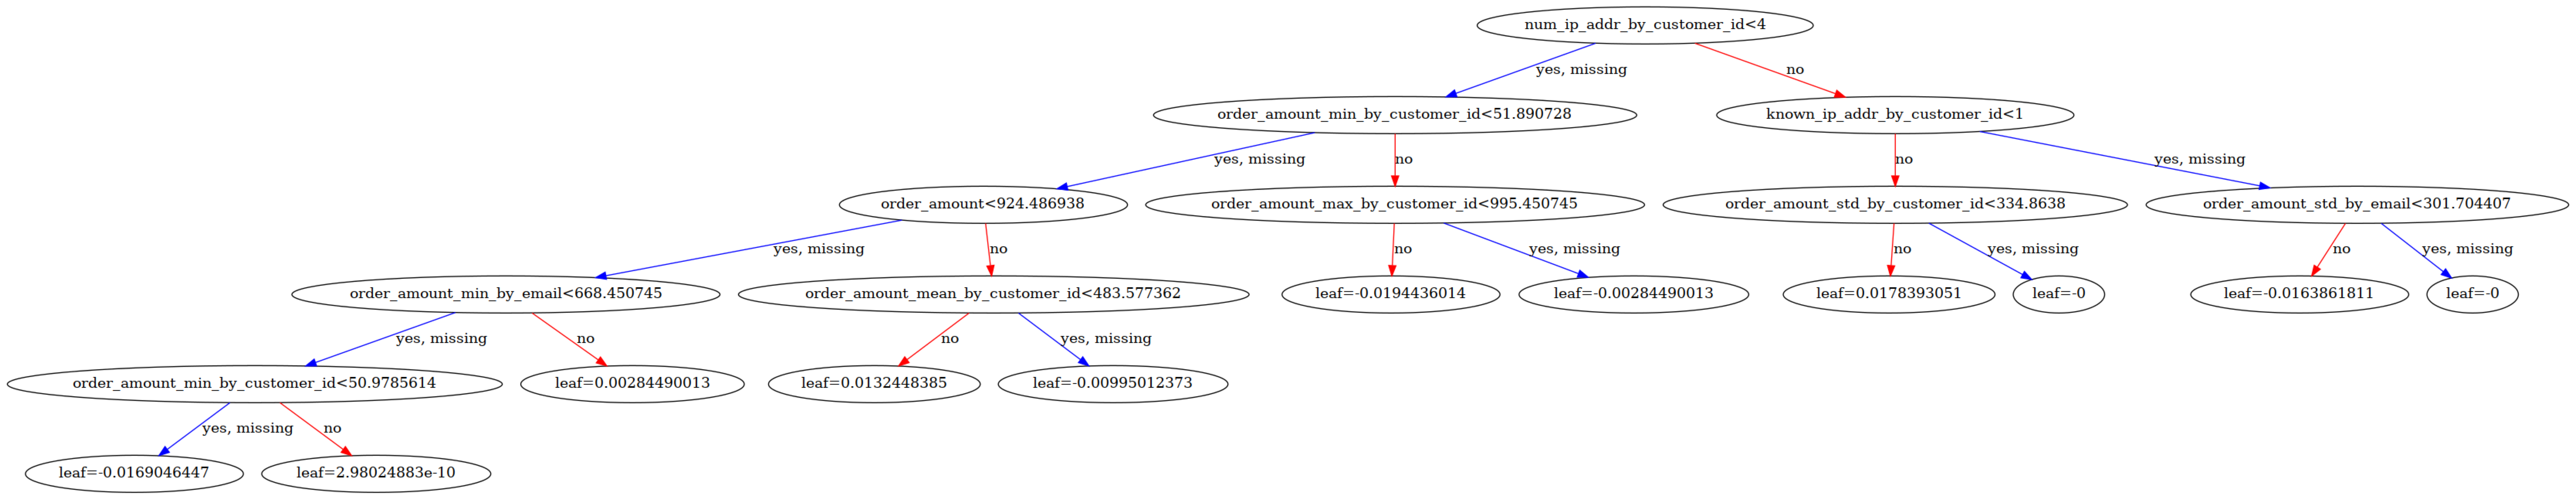

In [ ]:
import matplotlib.pyplot as plt
from xgboost import plot_tree

bst = _load_model(result.model_path)
plot_tree(bst, num_trees=1)
fig = plt.gcf()
fig.set_size_inches(100, 100)


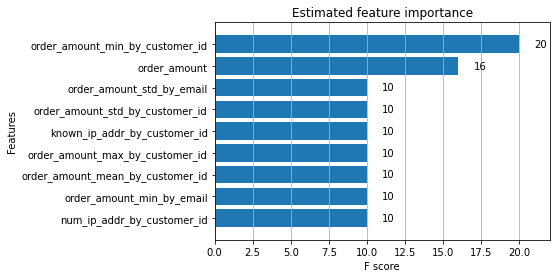

In [ ]:
%matplotlib inline
import matplotlib.pyplot as plt
import xgboost

ax = xgboost.plot_importance(bst, height=0.8, max_num_features=9)
ax.grid(False, axis="y")
ax.set_title('Estimated feature importance')
plt.show()

In [ ]:
client = get_client()
try:
    df = dd.read_parquet(result.validation_data, engine='fastparquet')
    X, y = _features_and_labels(df)
    y_hat = dask_xgboost.predict(client, bst, X).persist()
    y, y_hat = dask.compute(y, y_hat)
finally:
    client.close()

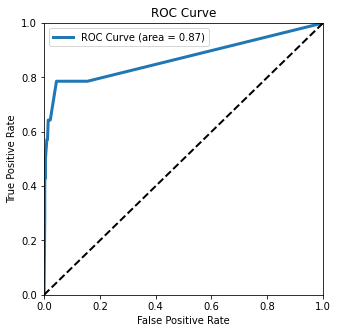

In [ ]:
from sklearn.metrics import roc_curve

fpr, tpr, _ = roc_curve(y, y_hat)

from sklearn.metrics import auc

fig, ax = plt.subplots(figsize=(5, 5))
ax.plot(fpr, tpr, lw=3,
        label='ROC Curve (area = {:.2f})'.format(auc(fpr, tpr)))
ax.plot([0, 1], [0, 1], 'k--', lw=2)
ax.set(
    xlim=(0, 1),
    ylim=(0, 1),
    title="ROC Curve",
    xlabel="False Positive Rate",
    ylabel="True Positive Rate",
)
ax.legend();
plt.show()